In [196]:
import numpy
import matplotlib.pyplot as plt

# Advanced Least Squares

In 7.1, we saw the simplest and classic method of solving for a straight best fit line for some data corrupted by noise. We introduced the matrix representation of the least squares solver as the quickest and easiest method to approximately solve for these coefficients. 

In this notebook we will break down the mathematics of this approach more clearly, including a deep dive into the linear algebra and solving step required. 

We will use a slightly more elaborate model example to help move things along. In our first example in 7.1, we saw how to solve a straight best-fit line: $y= mx + c$, which is essentially a first order polynomial expansion. We can also use a $N$-th order expansion:

$y = c + m_1x + m_2x^2 + \dots mx^N + \epsilon$

where $m_1$,$m_2$ correspond to our polynomial coefficients, and $x$ is our data. For now, we'll settle with a second order polynomial expansion:

$y = c + m_1x + m_2x^2 + \epsilon $

In [197]:
def generate_data(m1,m2,c,N,sigma):
    xvec = numpy.arange(0,10,10/N)
    noisevec = numpy.random.normal(0.0,sigma,size=N)
    return xvec,(c + m1*xvec + m2 * xvec**2 + noisevec)

In [198]:
xvec, data = generate_data(0.2,0.4,20.0,300,5.0)

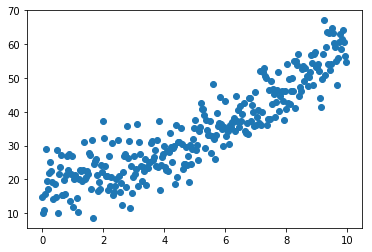

In [199]:
plt.scatter(xvec,data)
plt.show()

In [200]:
print(xvec[:,numpy.newaxis].shape)

(300, 1)


In [201]:
A = numpy.concatenate((xvec[:,numpy.newaxis],xvec[:,numpy.newaxis]**2,numpy.ones(xvec.shape[0])[:,numpy.newaxis]),axis=1)
B = data
x = numpy.linalg.lstsq(A,B,rcond=None)[0]

In [202]:
print(A.shape)
print(data.shape)
print(x)

(300, 3)
(300,)
[ 0.68518954  0.34862594 19.06547193]


In [203]:
print("Least Squares Variables:")
print("m1 = ",x[0])
print("m2 = ",x[1])
print("c = ",x[2])

Least Squares Variables:
m1 =  0.6851895401463552
m2 =  0.3486259390195854
c =  19.065471927543637


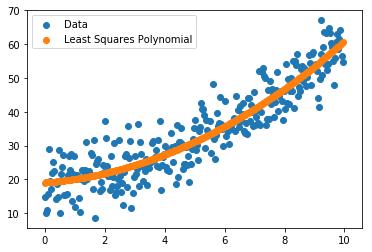

In [204]:
plt.scatter(xvec,data,label='Data')
plt.scatter(xvec,x[0]*xvec + x[1]*xvec**2 + x[2],label='Least Squares Polynomial')
plt.legend()
plt.show()

## Solving a Least Squares System (with a detour for conditioning)

The above worked quite nicely but so far we've worked purely with the numpy least squares solver, which makes life nice and easy for us.

Let's dive into how we really solve a system such as this through nuts and bolts linear algebra routines. 

As noted previously, we've been setting up our system using the least squares formulation:

$Ax = B$

where the goal is to minimise the "residuals" $||Ax - B||^2 $, where $||\:||^2$ is the eucliean 2-norm, such that:

$$||x||^2 = \sqrt{x_1^2 + x_2^2 + x_N^2 }$$

If we substitute in our system $Ax = B$ into this:

$$||Ax - B||^2 = (Ax - B)^T(Ax-B)$$

which when expanded out equals:

$$(Ax - B)^T(Ax-B) = x^TA^T A x - x^T A^T B - B^T A x + B^T B$$ 
where we can use $x^Ta^TB = B^TAx$ to simplify further, setting the whole quantity to minimise to $J$:

$$J = x^TA^T A x - 2x^T A^T B + B^T B$$

We want to minimise this residual, thus we want to reach a point where it no longer changes. We can do that by differentiating it and setting the resulting quantity to 0:

$$\frac{\partial J}{\partial x} = 2 A^T A x - 2 A^T B = 0$$

And then we can solve $2 A^T A x = 2 A^T B$ fairly easily:

$$A^T A x = A^T B \\
x = (A^T A)^{-1} A^T B $$

And there we have our least squares estimator. Now the problems that remain are:

1) How to invert $A^T A$ 
2) Conditioning of our system

Lets start with 1)

## Factorising Ax = B

Any matrix can be factorised into a product of other matrices. In our particular case we are interested in factorising $A^TA$. A is by definition not square, however $A^T A$ is a square matrix. There are several 
potential methods we could use, including the Cholesky Decomposition, LU Decomposition, or QR decomposition.

It's also worth pointing out that if $A$ is full rank then $A^T A$ is positive definite, which means we can use the very fast and efficient cholesky decomposition to factorize $(A^T A) = RR^T$, where $R$ is a triangular matrix.

This allows us to re-write our original equation as:

$RR^Tx = A^TB$

We can solve this by first factoring out $R^Tx$:

$$
\begin{align}
R^Tx = z \\
Rz = A^TB  
\end{align}
$$

As $R$ is is triangular, we can solve for $z$ first by forwards substitution from $Rz = A^TB$. We can then solve for $x$ by backwards substitution.

In [227]:
aat = numpy.dot(A.T,A)
uaat,saat,vhaat = numpy.linalg.svd(aat)

In [228]:
print("Condition Number:")
print(saat[0]/saat[-1])

Condition Number:
20931.67550813515


Not great, not terrible. If your condition number gets too high, you'll eventually be unable to solve the system depending on the floating point precision. 

Condition numbers greater than roughly $10^6$-$10^7$ will be unstable on single precision floating point arithmetic ('float'), and greater than $10^12$-$10^14$ will be unstable on double precision floating point arithmetic ('double')

In [215]:
R = numpy.linalg.cholesky(aat)

In [217]:
CholRhs = numpy.dot(A.T,B)

In [220]:
print(R)

[[ 99.74996519   0.           0.        ]
 [746.87578277 192.84106463   0.        ]
 [ 14.9874739   -6.449486     5.81203548]]


In [223]:
coeffs_lt = scipy.linalg.solve_triangular(R,CholRhs,lower=True)
coeffs_ut = scipy.linalg.solve_triangular(R.T,coeffs_lt,lower=False)

In [230]:
print("Least Squares Parameters:")
print("m1 =",coeffs_ut[0])
print("m2 =",coeffs_ut[1])
print("c =",coeffs_ut[2])

Least Squares Parameters:
m1 = 0.6851895401462282
m2 = 0.3486259390195973
c = 19.06547192754387


## Alternative Factorization: QR Decomposition

We can also do this using the QR decomposition. The QR decomposition has the benefit of enhanced
stability over other decomposition methods and works for both square and non-square systems.

For stability:

QR > Cholesky > LU

For Speed:

Cholesky > LU > QR

LU decompositions can be great in practice however for parallelised systems which is why I mention it, such as on a cluster or GPU, due to the pleasantly parallelisable nature of the partial and complete pivoting schemes in this decomposition.

There are various other factorisations depending on the exact properties of the the system $A$ that you are trying to solve! 

### QR Algorithm

From above we have the least squares estimator:

$A^TAx = A^TB$

The QR factorization allows us to factor $A = QR$, where $Q$ is an orthogonal matrix and $R$ is an upper triangular matrix. Expanding out we get:

$R^T Q^T Q R x = R^T Q^T B$

As $Q$ is orthogonal $Q^T Q = I$ where $I$ is the identity matrix:

$R^T R x = R^T Q^T B \\
Rx = Q^T B$

After multiplying $Q^T$ with $B$ we can then solve easily using a simple backwards subsitution triangular solver (or more elaborate blocked scheme). 

In [205]:
u,s,vh = numpy.linalg.svd(A)

In [206]:
print("Condition Number: ")
print(s[0]/s[-1])

Condition Number: 
144.6778335065102


In [207]:
q,r = numpy.linalg.qr(A,mode='reduced')

In [208]:
rhs = numpy.dot(q.T,B)

In [209]:
import scipy.linalg

In [210]:
coeffs = scipy.linalg.solve_triangular(r,rhs,lower=False)

In [211]:
print("Least Squares Parameters:")
print("m1 =",coeffs[0])
print("m2 =",coeffs[1])
print("c =",coeffs[2])

Least Squares Parameters:
m1 = 0.6851895401463503
m2 = 0.3486259390195856
c = 19.065471927543637


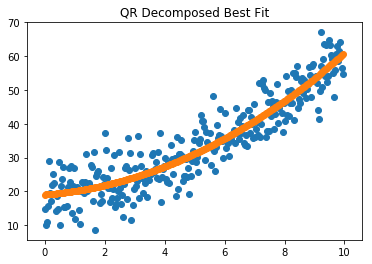

In [212]:
plt.title("QR Decomposed Best Fit")
plt.scatter(xvec,data)
plt.scatter(xvec,coeffs[0]*xvec + coeffs[1]*xvec**2 + coeffs[2])
plt.show()